In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path
from tabulate import tabulate

# load result files from all transformer models
train_normal = pd.read_csv('CognateTransformer/results/pretrainNormal/proto_plain_cog_detailed.tsv', sep='\t')
pretrain_normal = pd.read_csv('CognateTransformer/results/pretrainNormal/proto_pretrained_cog_detailed.tsv', sep='\t')
pretrain_semitic = pd.read_csv('CognateTransformer/results/pretrainSemitic/proto_pretrained_cog_detailed.tsv', sep='\t')
svm = pd.read_csv('supervised-reconstruction-paper/results/all-svm.tsv', sep='\t')
corpar = pd.read_csv('supervised-reconstruction-paper/results/all-corpar.tsv', sep='\t')

In [2]:
def process_transformer_results(df):
    # keep only entries with lng in ["ProtoBai", "ProtoBurmish", "ProtoPurus", "ProtoKaren", "ProtoLalo", "Latin", "ps"]
    df = df[df['lng'].isin(["ProtoBai", "ProtoBurmish", "ProtoPurus", "ProtoKaren", "ProtoLalo", "Latin", "ps"])]

    # # average over all validation sets
    # df = df.groupby(['test_prop', 'lng']).mean().reset_index()
    # # remove the valid column
    # df = df.drop(columns=['valid'])

    # replace 'ps' with 'ProtoSemitic'
    df['lng'] = df['lng'].replace('ps', 'ProtoSemitic')
    # remove "Proto" from the language names
    df['lng'] = df['lng'].str.replace('Proto', '')
    #replace Latin with Romance
    df['lng'] = df['lng'].replace('Latin', 'Romance')
    df['method'] = 'none'

    # rename B3_F1 to BC
    df = df.rename(columns={'B3_F1': 'BC'})
    
    return df

train_normal = process_transformer_results(train_normal)
pretrain_normal = process_transformer_results(pretrain_normal)
pretrain_semitic = process_transformer_results(pretrain_semitic)

/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_11271/4057365012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lng'] = df['lng'].replace('ps', 'ProtoSemitic')
/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_11271/4057365012.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lng'] = df['lng'].str.replace('Proto', '')
/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_11271/4057365012.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [3]:
# merge all models, keeping the model name under 'Model'
train_normal['classifier'] = 'CogTrBase'
pretrain_normal['classifier'] = 'CogTrPretrain'
pretrain_semitic['classifier'] = 'CogTrPretrainSemitic'
svm['classifier'] = 'svm'
corpar['classifier'] = 'corpar'


In [4]:
df = pd.concat([svm, corpar, train_normal, pretrain_normal, pretrain_semitic])
# take test_prop = 0.1, lng = Semitic and group by classifier and method, then take the mean of each metric (ED, NED, BC) tabulate for LaTeX
df = df[df['test_prop'] == 0.1]
df = df[df['lng'] == 'Semitic']
df = df.groupby(['classifier', 'method']).mean().reset_index()
df = df.drop(columns=['test_prop'])
df = df[['classifier', 'method', 'ED', 'NED', 'BC']]
df = df.round(4)
print(tabulate(df, headers='keys', tablefmt='latex', floatfmt=".4f"))

\begin{tabular}{rllrrr}
\hline
    & classifier           & method    &     ED &    NED &     BC \\
\hline
  0 & CogTrBase            & none      & 1.1808 & 0.2488 & 0.6883 \\
  1 & CogTrPretrain        & none      & 1.4195 & 0.2898 & 0.6801 \\
  2 & CogTrPretrainSemitic & none      & 1.5605 & 0.3135 & 0.6592 \\
  3 & corpar               & Ini       & 0.9818 & 0.2426 & 0.7219 \\
  4 & corpar               & Pos       & 0.9623 & 0.2366 & 0.7196 \\
  5 & corpar               & PosIni    & 0.9779 & 0.2401 & 0.7160 \\
  6 & corpar               & PosStr    & 0.9844 & 0.2420 & 0.7170 \\
  7 & corpar               & PosStrIni & 1.0091 & 0.2466 & 0.7057 \\
  8 & corpar               & Str       & 0.9948 & 0.2432 & 0.7192 \\
  9 & corpar               & StrIni    & 1.0273 & 0.2481 & 0.7132 \\
 10 & corpar               & none      & 1.0519 & 0.2618 & 0.7093 \\
 11 & svm                  & Ini       & 0.8429 & 0.2127 & 0.7491 \\
 12 & svm                  & Pos       & 0.8467 & 0.2122 & 0.7482

/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_11271/3928755957.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['classifier', 'method']).mean().reset_index()


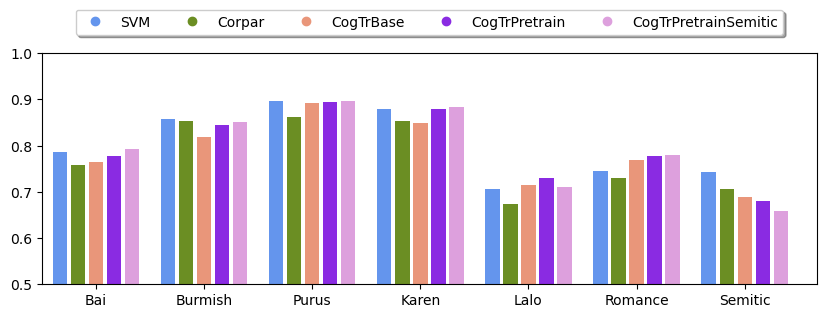

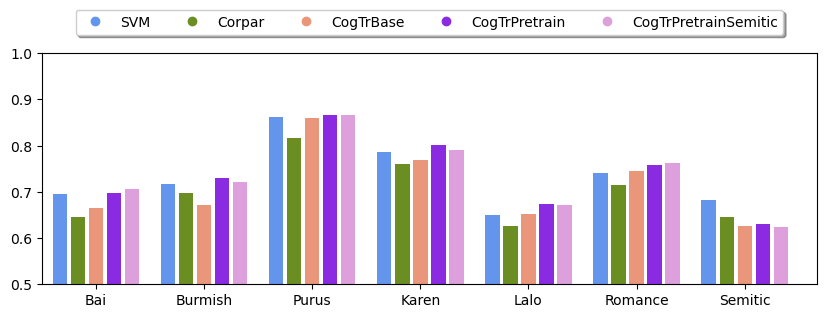

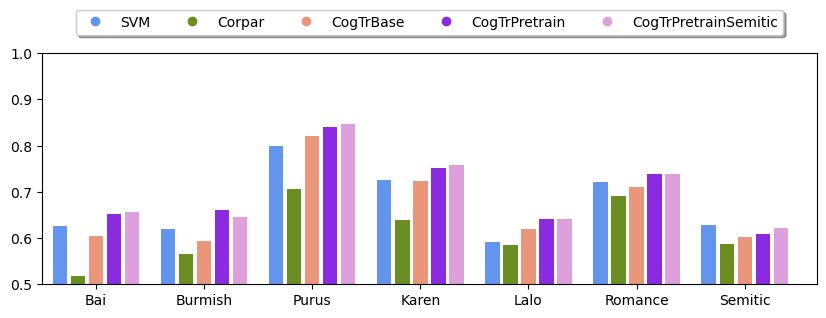

In [5]:
# A function to plot a comparison between the 5 different classifiers.
def plot_comparison_classifiers(df, proportions, transform, output_dir):
    for prop in proportions:
        ress, poss, colors = [], [], []
        idx = 0
        dslabels = df['lng'].unique()

        for ds in dslabels:
            # TODO: move the prop loop here and plot all methods on top of each other from smallest to largest prop
            for clf in ["svm", "corpar", "CogTrBase", "CogTrPretrain", "CogTrPretrainSemitic"]:
                mean_bc = df[(df['test_prop'] == prop) & 
                                (df['lng'] == ds) & 
                                (df['classifier'] == clf)]['BC'].mean()
                ress.append(mean_bc)
                poss.append(idx)
                colors.append(transform[clf][1])
                idx += 1
            idx += 1

        plt.figure(figsize=(10, 3))
        ax = plt.subplot(111)
        plt.bar(poss, ress, color=colors)
        for clf in ["svm", "corpar", "CogTrBase", "CogTrPretrain", "CogTrPretrainSemitic"]:
            plt.plot(-2, -2, "o", color=transform[clf][1],
                         label=transform[clf][0])
        plt.ylim(0.5, 1)
        plt.xlim(-1, len(ress) + 7)
        plt.xticks(range(2, len(ress) + 7, 6), dslabels)
        ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=5,
                  fancybox=True, shadow=True)
        plt.show()

# filter svm and corpar to include only where method is "PosStrIni"
svm_m = svm[svm['method'] == 'PosStrIni']
corpar_m = corpar[corpar['method'] == 'PosStrIni']
all_models = pd.concat([train_normal, pretrain_normal, pretrain_semitic, svm_m, corpar_m])

transform_classifiers = {
    "svm": ("SVM", "cornflowerblue"),
    "corpar": ("Corpar", "olivedrab"),
    "CogTrBase": ("CogTrBase", "darksalmon"),
    "CogTrPretrain": ("CogTrPretrain", "blueviolet"),
    "CogTrPretrainSemitic": ("CogTrPretrainSemitic", "plum")
}

plot_comparison_classifiers(all_models, [0.1, 0.5, 0.8], transform_classifiers, 'results')


# Plot results

In [6]:
def plot_single_classifier(df, clf, proportions, transform, output_dir):
    for prop in proportions:
        res, colors, poss = [], [], []
        idx = 0
        selected_methods = ["PosStrIni", "StrIni", "Str", "Ini", "none"]
        dslabels = df['lng'].unique()
        
        table = []
        for ds in dslabels:
            table.append([ds])
            for m in selected_methods:
                mean_bc = df[(df['test_prop'] == prop) & 
                             (df['lng'] == ds) & 
                             (df['method'] == m)]['BC'].mean()
                res.append(mean_bc)
                poss.append(idx)
                idx += 1
                colors.append(transform[m][1])
                table[-1].append(mean_bc)
            idx += 1
            
        plt.figure(figsize=(10, 4))
        plt.bar(poss, res, color=colors)
        for m in selected_methods:
            plt.plot(-2, -2, "o", color=transform[m][1], label=transform[m][0])
        plt.ylim(0.5, 0.92)
        plt.xlim(-1, len(res) + 7)
        plt.xticks(range(2, len(res) + 6, 6), labels=dslabels)
        plt.legend(loc=1)
        plt.savefig(Path(output_dir) / f"results-{clf}.pdf")

        print(tabulate(table, tablefmt="latex", headers=["DATASET"] + selected_methods, floatfmt=".4f"))

def plot_comparison(df, proportions, transform, output_dir):
    for prop in proportions:
        ress, poss, yerrs, colors = [], [], [], []
        idx = 0
        selected_methods = ["PosStrIni", "StrIni", "Ini", "none"]
        dslabels = df['lng'].unique()

        for ds in dslabels:
            for m in selected_methods:
                for clf in ["svm", "corpar"]:
                    mean_bc = df[(df['test_prop'] == prop) & 
                                 (df['lng'] == ds) & 
                                 (df['method'] == m) & 
                                 (df['classifier'] == clf)]['BC'].mean()
                    ress.append(mean_bc)
                    yerrs.append(df[(df['test_prop'] == prop) & 
                                    (df['lng'] == ds) & 
                                    (df['method'] == m) & 
                                    (df['classifier'] == clf)]['BC'].std())
                    poss.append(idx)
                    colors.append(transform[f"{m}-{clf}"][1])
                    idx += 1
            idx += 1

        plt.figure(figsize=(10, 3))
        ax = plt.subplot(111)
        plt.bar(poss, ress, color=colors, yerr=yerrs)
        for m in selected_methods:
            for clf in ["svm", "corpar"]:
                plt.plot(-2, -2, "o", color=transform[f"{m}-{clf}"][1],
                         label=transform[f"{m}-{clf}"][0])
        plt.ylim(0.5, 1)
        plt.xlim(-1, len(ress) + 7)
        plt.xticks(range(2, len(ress) + 1, 9), labels=dslabels)
        ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=4,
                  fancybox=True, shadow=True)
        plt.savefig(Path(output_dir) / "results-compared.pdf")


\begin{tabular}{lrrrrr}
\hline
 DATASET   &   PosStrIni &   StrIni &    Str &    Ini &   none \\
\hline
 Bai       &      0.7730 &   0.7776 & 0.7774 & 0.7755 & 0.7747 \\
 Burmish   &      0.8559 &   0.8629 & 0.8619 & 0.8605 & 0.8405 \\
 Purus     &      0.8790 &   0.8913 & 0.8794 & 0.8924 & 0.8927 \\
 Karen     &      0.8664 &   0.8740 & 0.8743 & 0.8732 & 0.8702 \\
 Lalo      &      0.6897 &   0.6843 & 0.6860 & 0.6865 & 0.7053 \\
 Romance   &      0.7376 &   0.7276 & 0.7085 & 0.7205 & 0.7411 \\
 Semitic   &      0.7246 &   0.7302 & 0.7347 & 0.7355 & 0.6977 \\
\hline
\end{tabular}
\begin{tabular}{lrrrrr}
\hline
 DATASET   &   PosStrIni &   StrIni &    Str &    Ini &   none \\
\hline
 Bai       &      0.6701 &   0.6737 & 0.6702 & 0.6736 & 0.6814 \\
 Burmish   &      0.7077 &   0.7198 & 0.7215 & 0.7233 & 0.7053 \\
 Purus     &      0.8386 &   0.8502 & 0.8557 & 0.8562 & 0.8632 \\
 Karen     &      0.7735 &   0.7821 & 0.7817 & 0.7812 & 0.7842 \\
 Lalo      &      0.6380 &   0.6397 & 0.6370 

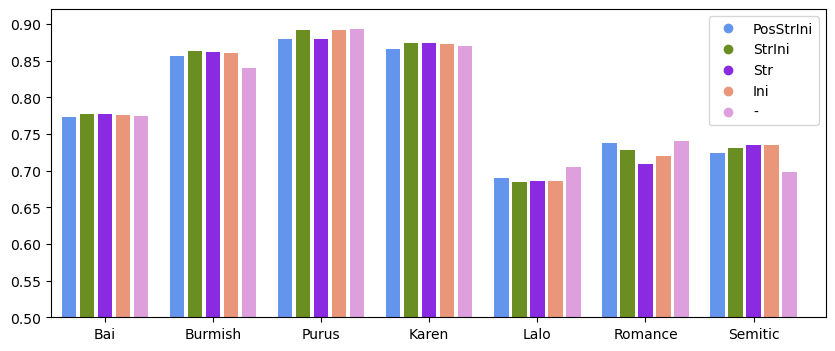

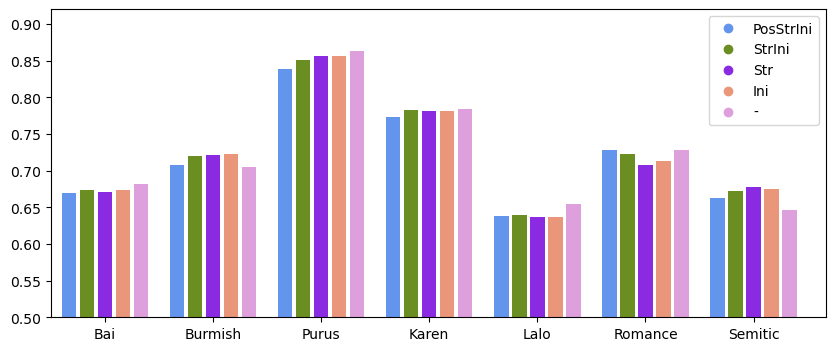

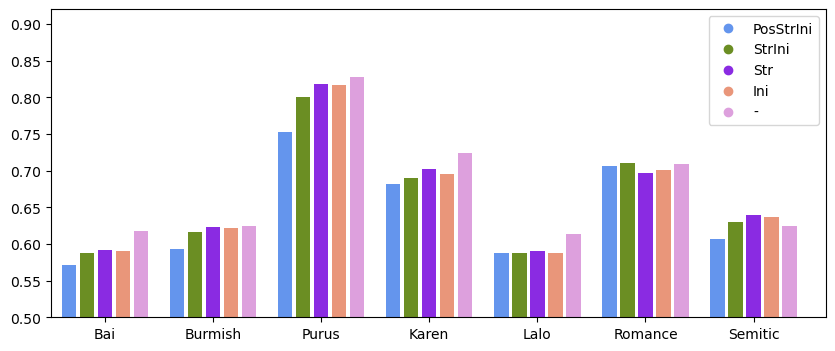

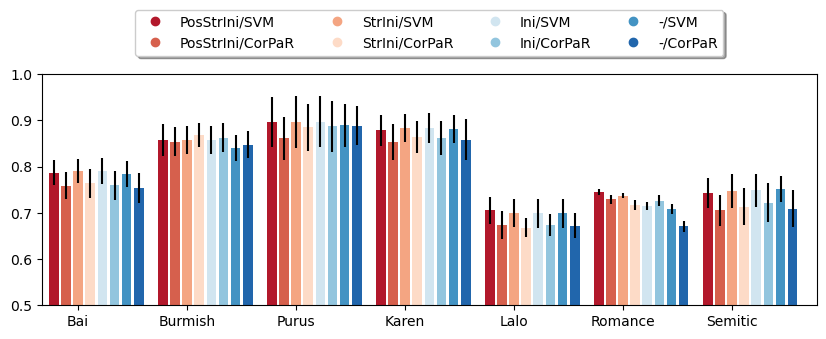

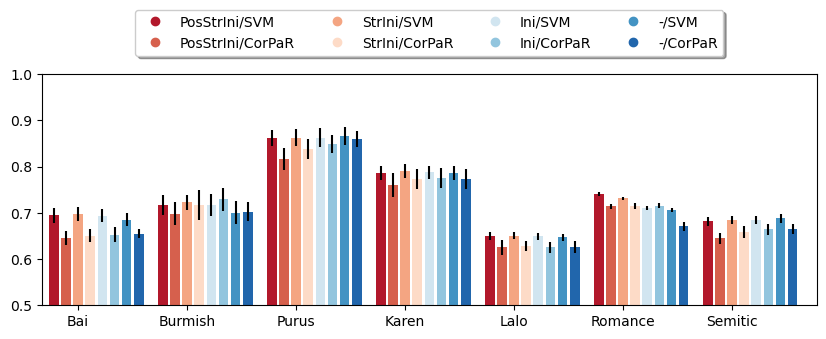

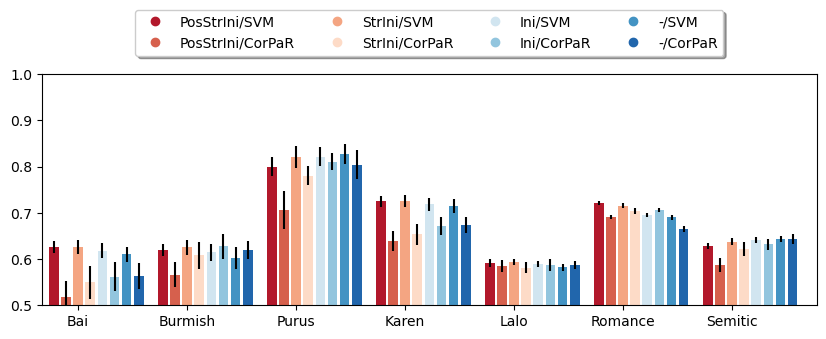

In [7]:
transform_single = {
    "PosStrIni": ("PosStrIni", "cornflowerblue"),
    "StrIni": ("StrIni", "olivedrab"),
    "Ini": ("Ini", "darksalmon"),
    "Str": ("Str", "blueviolet"),
    "none": ("-", "plum"),
}

transform_comparison = {
    "PosStrIni-svm": ("PosStrIni/SVM", "#b2182b"),
    "StrIni-svm": ("StrIni/SVM", "#f4a582"),
    "Ini-svm": ("Ini/SVM", "#d1e5f0"),
    "none-svm": ("-/SVM", "#4393c3"),
    "PosStrIni-corpar": ("PosStrIni/CorPaR", "#d6604d"),
    "StrIni-corpar": ("StrIni/CorPaR", "#fddbc7"),
    "Ini-corpar": ("Ini/CorPaR", "#92c5de"),
    "none-corpar": ("-/CorPaR", "#2166ac"),
}

output_dir = ""

df = pd.concat([train_normal, pretrain_normal, pretrain_semitic, svm, corpar])

proportions = [0.1, 0.5, 0.8]

# Plot single classifier results
plot_single_classifier(df, clf="svm", proportions=proportions, transform=transform_single, output_dir=output_dir)

# Plot comparison between classifiers
plot_comparison(df, proportions=proportions, transform=transform_comparison, output_dir=output_dir)
